In [2]:
import torch
import torch.nn as nn
import numpy as np
import os
import pandas as pd

In [4]:
# specify the directory where the CSV files are located
directory = 'data'

exclude_string = '2023'#all test data was created in 2023
dfs = []
count = 0
# training_data
for filename in os.listdir(directory):
    
    if filename.endswith('.csv') and exclude_string not in filename:
        # load the CSV file into a pandas DataFrame
        p = os.path.join(directory,filename)
        df = pd.read_csv(p,sep=';', decimal=",", header=None, skiprows=1)
        # do something with the DataFrame
        dfs.append(df)
        
        count +=1
        if count == 1250:
            break


print("Done")
num_files = len(dfs)

Done


In [5]:
data = np.zeros((num_files,500,32,32))
for trajectory_index in range(1,len(dfs)):
    for iteration_index in range(1):
        obj = np.array(dfs[trajectory_index].loc[iteration_index,4].split(',')).reshape((32,32))
        for line in range(32):
            for row in range(32):
                        data[trajectory_index,iteration_index,line,row] = float(obj[line,row])


                        
print("Done")


Done


In [6]:
# Here I'll create some dummy numpy data with similar dimensionality as your data

trajectories_numpy_raw = data

print("The data should have shape:", trajectories_numpy_raw.shape)
print("Which corresponds to [T x F x D1 x D2]: 10 independent trajectories (T), 500 frames in each trajectory (F) for a system of size 32 x 32 (D1, D2)")

The data should have shape: (1250, 500, 32, 32)
Which corresponds to [T x F x D1 x D2]: 10 independent trajectories (T), 500 frames in each trajectory (F) for a system of size 32 x 32 (D1, D2)


In [7]:
# lets reverse some trajectory and get labels to train on

# Draw indices to flip
toFlip = np.random.choice([0,1], size=trajectories_numpy_raw.shape[0])

# flip
trajectories_numpy = trajectories_numpy_raw.copy()
trajectories_numpy[toFlip] = trajectories_numpy_raw[toFlip][::-1]

# Create Labels
labels_numpy = np.zeros(trajectories_numpy.shape[0]).reshape(-1,1)
labels_numpy[toFlip == 0] = 1

print("\nThe labels should have shape:", labels_numpy.shape)
print("Which corresponds to [T x 1]: The one in the last dimension is VERY important, use .reshape(-1,1) if you lose it at some point.")

print("\nThe labels indicate if a trajectory is in correct direction (1) or reversed (0)")



The labels should have shape: (1250, 1)
Which corresponds to [T x 1]: The one in the last dimension is VERY important, use .reshape(-1,1) if you lose it at some point.

The labels indicate if a trajectory is in correct direction (1) or reversed (0)


In [8]:
# Convert to pytorch tensor

trajectories_tensor = torch.from_numpy(trajectories_numpy.astype(np.float32))
labels_tensor = torch.from_numpy(labels_numpy.astype(np.float32))


In [9]:
# Create a dataset
full_dataset = torch.utils.data.TensorDataset(trajectories_tensor, labels_tensor)

# Split into test and training data
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [int(len(full_dataset) * 0.9), len(full_dataset) - int(len(full_dataset) * 0.9)])

# Create a data loader for train and test sets
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [10]:
# Let's define some neural networks

# First up a simple feedforward network, with some hidden layers and 
# a sigmoid activation in the end to restrict the ouput between 0 and 1

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers):
        super(MLP, self).__init__()
        
        self.activation = nn.ReLU()

        modules = []

        modules.append(nn.Linear(input_size, hidden_size))

        for  k in range(n_layers - 2):
            modules.append(self.activation)
            modules.append(nn.Linear( hidden_size, hidden_size))

        modules.append(self.activation)
        modules.append(nn.Linear(hidden_size, 1))

        modules.append(nn.Sigmoid())

        self.net = nn.Sequential(*modules)

    def forward(self, X):

        return self.net(X)


# secondly a VERY simple convolutional network with a 3x3 filter reducing 
# the frames (channels) and a linear layer for the output

class CNN(nn.Module):
    def __init__(self, trajectory_length, N_spins, N_channels_hidden = 10):
        super(CNN, self).__init__()
        
        self.activation = nn.ReLU()

        modules_cnn = []

        modules_cnn.append(nn.Conv2d(trajectory_length, N_channels_hidden, 3))
        modules_cnn.append(self.activation)

        modules_cnn.append(nn.Conv2d(N_channels_hidden, 1, 3))
        modules_cnn.append(self.activation)


        modules_linear = []
        modules_linear.append(nn.Linear((N_spins-4) * (N_spins-4), 1))
        modules_linear.append(nn.Sigmoid())


        self.net = nn.Sequential(*modules_cnn)
        self.linear_net = nn.Sequential(*modules_linear)

    def forward(self, X):

        X = self.net(X)

        X = X.reshape(X.shape[0], X.shape[2] * X.shape[3])
        
        return self.linear_net(X)

In [11]:

# Our train loop, very similar to the example on the pytorch website

def train_model(N_epochs, model, train_dataloader, test_dataloader):

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    loss_history = []
    for epoch in range(N_epochs):

        train_losses, test_losses = [], []

        for i, (data, labels) in enumerate(train_dataloader):
            
            optimizer.zero_grad()
            
            y_pred = model(data)

            loss = criterion(y_pred, labels )
            
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
        

        with torch.no_grad():
            
            accuracy = 0
            for i, (data, labels) in enumerate(test_dataloader):
                    
                y_pred = model(data)
                loss = criterion(y_pred, labels )

                accuracy += (y_pred.round() == labels).sum().item()
                
                test_losses.append(loss.item())

        accuracy /= len(test_dataloader.dataset)

        loss_history.append([np.average(train_losses), np.average(test_losses), accuracy])

        print("Epoch {:04d}/{}: Train Loss: {:.4f} | Test Loss: {:.4f}\tAcc.: {:.4f} ".format(epoch, N_epochs, np.average(train_losses), np.average(test_losses), accuracy))

    return np.array(loss_history)

In [15]:
# Define a model
model = CNN(trajectory_length=500, N_spins=32, N_channels_hidden=5)

In [16]:
# train the model for 10 epochs
loss_history = train_model(10, model=model, train_dataloader=train_dl, test_dataloader=test_dl)

Epoch 0000/10: Train Loss: 0.6932 | Test Loss: 0.6948	Acc.: 0.4560 
Epoch 0001/10: Train Loss: 0.6932 | Test Loss: 0.6947	Acc.: 0.4560 
Epoch 0002/10: Train Loss: 0.6932 | Test Loss: 0.6943	Acc.: 0.4560 
Epoch 0003/10: Train Loss: 0.6933 | Test Loss: 0.6941	Acc.: 0.4560 
Epoch 0004/10: Train Loss: 0.6931 | Test Loss: 0.6938	Acc.: 0.4560 
Epoch 0005/10: Train Loss: 0.6932 | Test Loss: 0.6935	Acc.: 0.4560 
Epoch 0006/10: Train Loss: 0.6931 | Test Loss: 0.6935	Acc.: 0.4560 
Epoch 0007/10: Train Loss: 0.6930 | Test Loss: 0.6937	Acc.: 0.4560 
Epoch 0008/10: Train Loss: 0.6931 | Test Loss: 0.6940	Acc.: 0.4560 
Epoch 0009/10: Train Loss: 0.6933 | Test Loss: 0.6942	Acc.: 0.4560 


Text(0, 0.5, 'Test Accuracy')

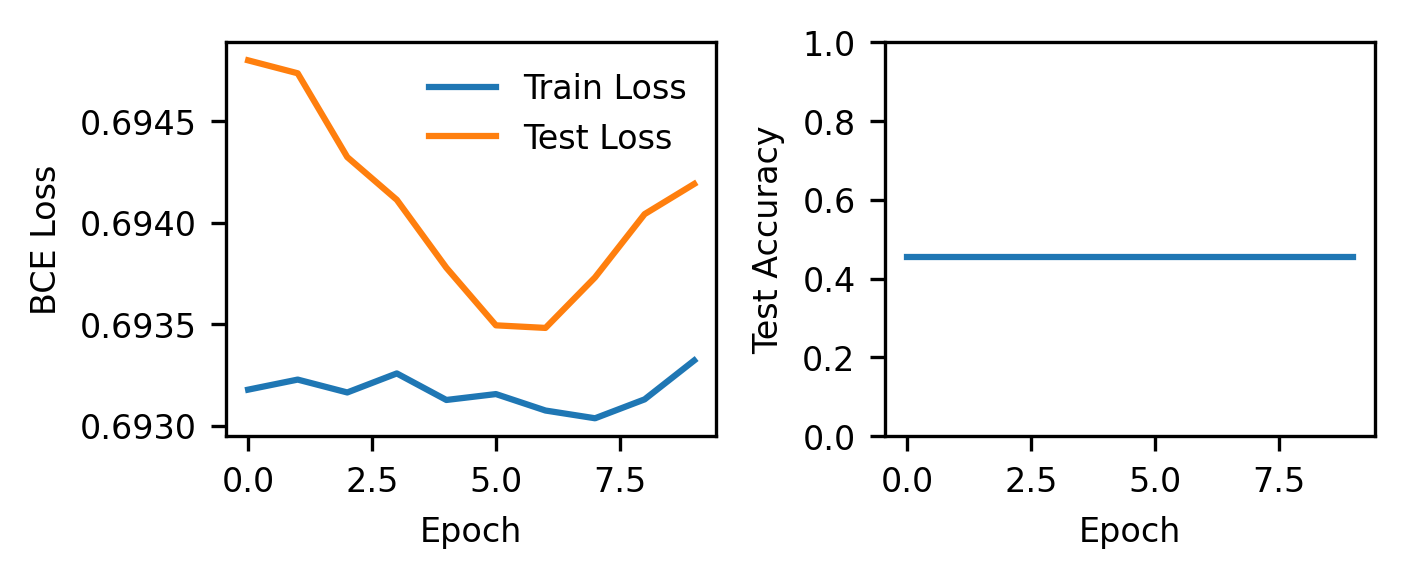

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({'font.size': 8})

fig_size = (12 * 0.393701, 5 * 0.393701) # cm -> inch: 0.393701 

fig, ax = plt.subplot_mosaic([["losses", "accuracy"]],
                               layout="tight", 
                               figsize = fig_size, dpi = 300,
                               )

ax["losses"].plot(loss_history[:,0], label="Train Loss")
ax["losses"].plot(loss_history[:,1], label="Test Loss")

ax["losses"].legend(frameon=False)
ax["losses"].set_xlabel("Epoch")
ax["losses"].set_ylabel("BCE Loss")


ax["accuracy"].plot(loss_history[:,2])

ax["accuracy"].set_ylim(0, 1)
ax["accuracy"].set_xlabel("Epoch")
ax["accuracy"].set_ylabel("Test Accuracy")